# Kütüphanelerin Yüklenmesi

In [1]:
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Fonksiyonlar

In [2]:
def process_df(data_dir, processed_dir, classes, num_images=650):
    """
    Ana veri setinden belirli sınıflara ait hayvanların ve belirli bir sayıdaki 
    resimlerin yeni dosya olarak oluşturulması. 

    Args:
        data_dir (str): Ana veri setinin bulunduğu kök dizin.
        processed_dir (str): İşlenmiş verilerin saklanacağı hedef dizin. 
        classes (list): Verinin sınıf isimlerini içeren liste.
        num_images (int): Her bir sınıf için kopyalanacak maksimum resim sayısı. Varsayılan 650.

    Returns:
        dict: Her sınıf için kopyalanan dosyaların dizinlerini içeren bir sözlük.  
    """
    copied_files = {}
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        target_dir = os.path.join(processed_dir, cls)
        os.makedirs(target_dir, exist_ok=True)

        # Her sınıf için ilk `num_images` resmi kopyala
        images = sorted(os.listdir(class_dir))[:num_images]
        copied_files[cls] = []
        for img in images:
            source_path = os.path.join(class_dir, img)
            target_path = os.path.join(target_dir, img)
            shutil.copy(source_path, target_path)
            copied_files[cls].append(target_path)

    return copied_files

def split_data(copied_files, processed_dir, classes, test_size=0.2, random_state=42):
    """
    Verileri eğitim ve test dizinlerine ayıran fonksiyon.

    Args:
        copied_files (dict): Sınıf isimlerini anahtar ve resim dosyalarının listelerini değer olarak içeren sözlük.
        processed_dir (str): İşlenen verilerin ana dizini.
        classes (list): Sınıf isimlerini içeren liste.
        test_size (float): Test setinin oranı (varsayılan 0.2).
        random_state (int): Rastgelelik için sabit bir değer (varsayılan 42).

    Returns:
        tuple: (train_dir, test_dir) Eğitim ve test dizinlerinin yolları.
    """
    # Eğitim ve test dizinlerini oluştur
    train_dir = os.path.join(processed_dir, "train")
    test_dir = os.path.join(processed_dir, "test")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for cls in classes:
        # Her sınıf için eğitim ve test dizinlerini oluştur
        train_class_dir = os.path.join(train_dir, cls)
        test_class_dir = os.path.join(test_dir, cls)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Verileri eğitim ve test setlerine ayır
        train_images, test_images = train_test_split(
            copied_files[cls], test_size=test_size, random_state=random_state
        )

        # Resimleri eğitim dizinine kopyala
        for img in train_images:
            shutil.copy(img, train_class_dir)

        # Resimleri test dizinine kopyala
        for img in test_images:
            shutil.copy(img, test_class_dir)

    return train_dir, test_dir

def preprocess_with_generator(train_dir, test_dir, target_size=(64, 64), batch_size=32):
    """
    Verileri ön işleme için veri arttırma (data augmentation) ve ölçeklendirme yapılması.
    Eğitim ve test verileri için ImageDataGenerator kütüphanesi kullanılarak veri ölçeklendirme ve arttırma işleminin yapılması.

    Args:
        train_dir (str): Eğitim verisinin bulunduğu dizin yolu.
        test_dir (str): Test verisinin bulunduğu dizin yolu.
        target_size (tuple): Resimlerin yeniden boyutlandırılacağı hedef boyut (varsayılan: (64, 64)).
        batch_size (int): Jeneratörlerin döndüreceği mini-batch boyutu (varsayılan: 32).

    Returns:
        tuple: (train_generator, test_generator) Eğitim ve test verileri.
    """
    
    datagen = ImageDataGenerator(
                                    rescale=1.0/255.0, # Piksel değerlerini 0-1 arasına ölçeklendirir.
                                    rotation_range=30, # Resimleri rastgele döndürür.
                                    width_shift_range=0.2, # Genişlikte kaydırma yapar.
                                    height_shift_range=0.2, # Yükseklikte kaydırma yapar.
                                    shear_range=0.2, # Resimlere kaydırma uygulama miktarı.
                                    zoom_range=0.2, # Resimlere rastgele yakınlaştırma uygular.
                                    horizontal_flip=True, # Resimleri yatay olarak rastgele çevirir.
                                    fill_mode='nearest' # Eksik pikselleri doldurma.
)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', # Sınıf etiketlerini kategorik (one-hot encoded) formatta döndürür.
        shuffle= True # Eğitim verisini rastgele karıştırır.
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle= False
    )

    return train_generator, test_generator

def plot_performance(history):
    """
    Eğitim ve doğrulama performansı olan doğurulama doğruluğun (accuracy) ve kayıp fonksiyonun (loss) epoch bazında görselleştirir.

    Args:
        history: Modelin eğitim sürecinde kaydedilen metrikler ve kayıpları içeren geçmiş nesnesi.

    Returns:
        None
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

### Fundamental functions
def linearize_image(image):
    """
    Converts an sRGB image to linear RGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.04045,
                    image / 12.92,
                    ((image + 0.055) / 1.055) ** 2.4)


def linear_to_srgb(image):
    """
    Converts a linear RGB image to sRGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.0031308,
                    image * 12.92,
                    1.055 * (image ** (1 / 2.4)) - 0.055)


def handle_saturation(image, lower=0.05, upper=0.95):
    """
    Creates a mask for non-saturated pixels (those between `lower` and `upper` thresholds)
    """
    return np.all((image > lower) & (image < upper), axis=-1)



### Color constancy
def estimate_light_source_grey_world(image, mask):
    """
    Estimates the light source based on the Grey World assumption, using valid pixels from the mask
    """
    valid_pixels = image[mask]
    avg_color = np.mean(valid_pixels, axis=0)
    return avg_color / np.linalg.norm(avg_color)


def correct_colors(image, light_source):
    """
    Corrects the colors of the image by applying white balance using the estimated light source
    """
    return image * (1.0 / light_source)


def manipulate_light_source(image, light_color):
    """
    Simulates color manipulation under a different light source

    Args:
    - image: The input image (sRGB, [0, 1])
    - light_color: The light source color (unit norm RGB vector)

    Returns:
    - Manipulated image (sRGB, [0, 1])
    """
    # Step 1: Linearize the image
    linear_image = linearize_image(image)

    # Step 2: Apply the light source (multiplying the linear image by the light color)
    manipulated_image = linear_image * light_color

    # Step 3: Convert the manipulated image back to sRGB
    manipulated_srgb = linear_to_srgb(manipulated_image)

    return np.clip(manipulated_srgb, 0, 1) 


def process_and_white_balance(image):
    """
    Applies white balance using both the Grey World and Max RGB methods
    Returns both corrected images in sRGB format
    """
    linear_image = linearize_image(image)
    valid_mask = handle_saturation(linear_image)

    # Light source estimations
    grey_world_light = estimate_light_source_grey_world(linear_image, valid_mask)

    # Color correction using both light sources
    corrected_grey_world = correct_colors(linear_image, grey_world_light)

    # Convert back to sRGB
    srgb_grey_world = linear_to_srgb(corrected_grey_world)

    # Clip and return
    return np.clip(srgb_grey_world, 0, 1)


# Light sources for color manipulation
def get_light_sources():
    """
    Returns a set of light sources for image manipulation
    """
    purplish_light = np.array([0.82, 0.15, 0.89]) / np.linalg.norm([0.82, 0.15, 0.89])
    yellowish_light = np.array([0.96, 0.24, 0.11]) / np.linalg.norm([0.96, 0.24, 0.11])
    greenish_light = np.array([0.11, 0.98, 0.12]) / np.linalg.norm([0.11, 0.98, 0.12])
    return purplish_light, yellowish_light, greenish_light


def get_wb_images(image):
    """
    Process and white balance the image
    """
    
    srgb_grey_world = process_and_white_balance(image)

    # Save the white-balanced images
    #cv2.imwrite('white_balanced_grey_world.jpg', cv2.cvtColor((srgb_grey_world*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    return srgb_grey_world


def get_manipulated_images(image):
    """
    Get manipulated images by applying color vectors
    """
    
    # Get the color vectors
    purplish_light, orangish_light, greenish_light = get_light_sources()

    # Manipulate the images under different light sources
    manipulated_purplish = manipulate_light_source(image, purplish_light)
    manipulated_orangish = manipulate_light_source(image, orangish_light)
    manipulated_greenish = manipulate_light_source(image, greenish_light)

    return manipulated_purplish, manipulated_orangish, manipulated_greenish


def save_manipulated_images(test_image_dir, output_dir):
    """
    Test seti dizinindeki (alt dizinler dahil) tüm resimleri işleyerek manipüle edilmiş versiyonlarını çıktı dizinine kaydeder.
    
    Args:
        test_image_dir () : Manipüle edilecek Test dizini.
        output_dir () : Manipüle edilmiş verilerin çıktı dizini.
        
    Returns:
    None
    """
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images_processed = False

    for root, dirs, files in os.walk(test_image_dir):
        for img_name in files:
            img_path = os.path.join(root, img_name)

            
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Read the image
                image = cv2.imread(img_path)
                
                if image is None:
                    print(f"Warning: Unable to read image {img_name}, skipping.")
                    continue  # Skip if image cannot be read

                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resimlerin manipüle edilmesi
                manipulated_purplish, manipulated_orangish, manipulated_greenish = get_manipulated_images(image_rgb)

                # Manipüle edilmiş resimlerin kaydedilmesi
                relative_path = os.path.relpath(root, test_image_dir)
                output_subdir = os.path.join(output_dir, relative_path)

                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                base_name = os.path.splitext(img_name)[0]
                
                # Mor version
                purplish_path = os.path.join(output_subdir, f'{base_name}_purplish.jpg')
                cv2.imwrite(purplish_path, cv2.cvtColor((manipulated_purplish * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

                # Turuncu version
                orangish_path = os.path.join(output_subdir, f'{base_name}_orangish.jpg')
                cv2.imwrite(orangish_path, cv2.cvtColor((manipulated_orangish * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

                # Yeşil version
                greenish_path = os.path.join(output_subdir, f'{base_name}_greenish.jpg')
                cv2.imwrite(greenish_path, cv2.cvtColor((manipulated_greenish * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

                images_processed = True

    if images_processed:
        print(f"Manipüle edilmiş resimler başarılı bir şekilde {output_dir} dizinine başarılı bir şekilde kaydedilmiştir!")
    else:
        print(f"{test_image_dir} dizininde geçerli resim bulunamadı veya hiç resim işlenmedi.")


def save_manipulated_col_images(test_image_dir, output_dir):
    """
    Test setindeki tüm görüntüleri (alt dizinler dahil) işleyip manipüle edilmiş versiyonlarını 
    çıktı dizinine kaydeder.

    Args:
        test_image_dir () : Manipüle edilecek Test dizini.
        output_dir () : Manipüle edilmiş verilerin çıktı dizini.
        
    Returns:
    None
    """
    # Eğer çıktı dizini yoksa, oluşturuluyor
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Herhangi bir görüntü işlenip işlenmediğini kontrol etmek için bayrak
    images_processed = False

    # Test dizinindeki tüm alt dizinler ve görüntüler üzerinde döngü
    for root, dirs, files in os.walk(test_image_dir):
        for img_name in files:
            img_path = os.path.join(root, img_name)

            # Dosyanın bir görüntü olup olmadığını kontrol et (gerektiğinde daha fazla uzantı eklenebilir)
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Görüntüyü oku
                image = cv2.imread(img_path)
                
                if image is None:
                    print(f"Uyarı: {img_name} görüntüsü okunamadı, atlanıyor.")
                    continue  # Görüntü okunamazsa atlanır

                # Görüntüyü RGB formatına çevir
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Beyaz dengesi (white balance) için işlemi uygula
                srgb_grey_world = get_wb_images(image_rgb)

                # Manipüle edilen görüntüleri çıktı dizinine kaydet
                # Çıktı görüntüsünün, giriş dizin yapısını koruyacak şekilde göreli yolunu oluştur
                relative_path = os.path.relpath(root, test_image_dir)
                output_subdir = os.path.join(output_dir, relative_path)

                # Eğer çıktı alt dizini yoksa, oluşturuluyor
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                # Görüntü ismi için temel ad (uzantısı olmadan)
                base_name = os.path.splitext(img_name)[0]
                
                # Renkli görüntü için dosya yolu
                color_path = os.path.join(output_subdir, f'{base_name}_color.jpg')
                # Manipüle edilmiş görüntüyü kaydet (RGB'yi BGR'ye dönüştürüp)
                cv2.imwrite(color_path, cv2.cvtColor((srgb_grey_world * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

                # Görüntü işlendikten sonra bayrağı True yap
                images_processed = True

    # Eğer herhangi bir görüntü işlenmişse, başarılı mesajı göster
    if images_processed:
        print(f"Renkli görüntüler başarıyla {output_dir} dizinine kaydedildi!")
    else:
        print(f"{test_image_dir} dizininde geçerli görüntü bulunamadı veya işlem yapılmadı.")

# Veri Seti hazırlama 

## Veri setinin hazırlanıp Train-Test dosyalarının oluşturulması 

Veri setimizi oluşturmak için ***process_df*** adında bir fonksiyon oluşturduk. Bu fonksiyon, 10 farklı hayvan türüne ait fotoğraflardan ilk 650 tanesini alarak dosya düzenlemesi yaptı. Daha sonra veri setimizi eğitim (train) ve test olarak ayırıp, bunları ayrı dosyalarda kaydettik.

In [3]:
# Kaggle dosya yolları ve örneklerin belirlenmesi
data_dir = '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages'

processed_dir = '/kaggle/working/processed_animals/'

classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

copied_files = process_df(data_dir, processed_dir, classes, num_images=650)

In [4]:
train_dir, test_dir = split_data(copied_files, processed_dir, classes, test_size=0.2, random_state=42)

## Veri arttırma (Data Augmentation) işlemleri

***process_with_generator*** fonksiyonu, TensorFlow kütüphanesindeki ImageDataGenerator fonksiyonu yardımıyla eğitim verileri üzerinde aşağıdaki işlemleri gerçekleştirdi:

Normalizasyon,

Yeniden boyutlandırma,

Resimleri 30 derece döndürme,

Genişlik ve yükseklik kaydırma,

Resim yakınlaştırma,

Resimleri rastgele yatay olarak çevirme.

Test veri setine ise yalnızca normalizasyon ve yeniden boyutlandırma işlemleri uygulandı. Ayrıca bu fonksiyon, etiketlerin kategorik olduğunu belirlemek için kullanıldı.

In [5]:
train_generator, test_generator = preprocess_with_generator(train_dir, test_dir)

Found 5200 images belonging to 10 classes.
Found 1300 images belonging to 10 classes.


# Model Oluşturma

## CNN Model Mimarisinin oluşturulması ve eğitilmesi 

İkinci aşamada, TensorFlow kullanılarak bir model mimarisi oluşturuldu. Bu mimari, görüntü sınıflandırması için tasarlanmıştır ve aşağıdaki adımlardan oluşur:

* Girdi (Input): 64x64 piksel RGB görüntüler,

* Özellik çıkarımı için iki evrişimsel (convolutional) katman,

* Boyut küçültme için iki maksimum havuzlama (max pooling) katmanı,

* Sınıflandırma için yoğun (dense) katmanlar,

* 10 sınıf arasında olasılık dağılımını veren bir çıktı katmanı.

Optimizasyon için *Adam algoritması* kullanılmış olup, öğrenme oranı (learning rate) 0.001 olarak belirlenmiştir. 

*Kayıp fonksiyonu* (loss function) olarak categorical_crossentropy seçilmiştir. 

Aşırı öğrenmeyi (overfitting) önlemek amacıyla *EarlyStopping* kütüphanesinden faydalanılmıştır.

In [6]:

model = Sequential([
    
        Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(64,64,3)),
        MaxPooling2D((2,2)),
        
        Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D((2,2)),
        #dense
        Flatten(),
        Dense(128,activation='relu'),
        Dense(10,activation='softmax') 
])
     

model.compile(optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 451ms/step - accuracy: 0.2374 - loss: 2.0717 - val_accuracy: 0.4538 - val_loss: 1.5902
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 440ms/step - accuracy: 0.4096 - loss: 1.6844 - val_accuracy: 0.4838 - val_loss: 1.5204
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 443ms/step - accuracy: 0.4513 - loss: 1.5785 - val_accuracy: 0.5246 - val_loss: 1.4063
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 456ms/step - accuracy: 0.4899 - loss: 1.4665 - val_accuracy: 0.5662 - val_loss: 1.2713
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 445ms/step - accuracy: 0.5241 - loss: 1.3832 - val_accuracy: 0.5715 - val_loss: 1.3072
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 447ms/step - accuracy: 0.5340 - loss: 1.3572 - val_accuracy: 0.5938 - val_loss: 1.2051
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 445ms/step - accuracy: 0.5623 - loss: 1.2729 - val_accuracy: 0.5546 - val_loss: 1.2636
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.5474 - loss: 1.2681 - val

## Oluşturulan mimarinin Model Performans değerlendirmesi

Modelin performansını değerlendirmek için ***plot_performance*** fonksiyonu kullanıldı. Bu fonksiyon, eğitim ve doğrulama kayıplarını/başarılarını grafik üzerinde göstermektedir. Modelin doğruluk oranı **%68** olarak bulunmuştur.

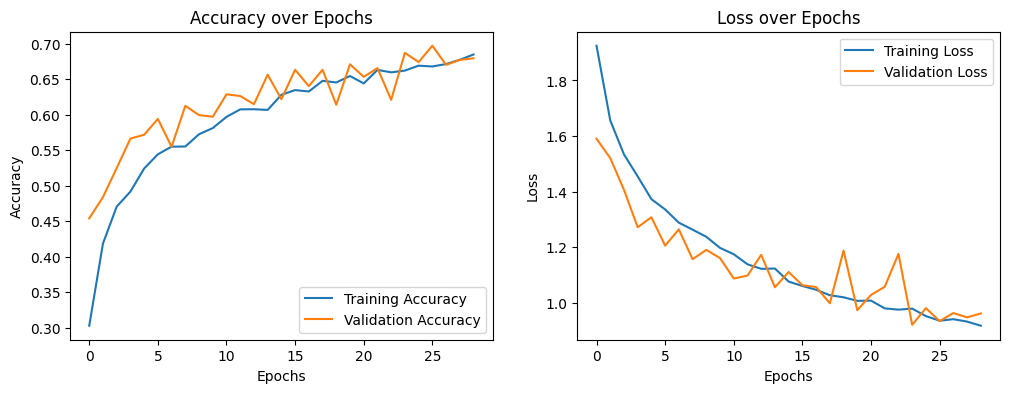

In [8]:
# Eğitim ve doğrulama kayıplarını/başarılarını çizdirme
plot_performance(history)

In [9]:
 history.history['val_accuracy'][-1]

0.6792307496070862

# Manipülasyon İşlemleri

## Farklı Işıklar ile Manipülasyon

***save_manipulated_images*** fonksiyonu, test verilerini manipüle ederek mor, turuncu ve yeşil ışık altında değişiklikler uygular. Bu manipüle edilmiş veriler bir dosyada saklanır ve model, bu yeni test verileriyle yeniden eğitilir. Daha sonra, modelin yeni veriler üzerindeki başarısı ***plot_performance*** fonksiyonu kullanılarak değerlendirilir.

In [10]:
test_image_dir= '/kaggle/working/processed_animals/test'

output_man_dir = '/kaggle/working/manipulated_images'

save_manipulated_images(test_image_dir, output_man_dir)

Manipüle edilmiş resimler başarılı bir şekilde /kaggle/working/manipulated_images dizinine başarılı bir şekilde kaydedilmiştir!


In [11]:
test_data_generator = ImageDataGenerator(rescale=1.0/255.0)

test_generator_manipulated = test_data_generator.flow_from_directory(output_man_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle= False
    )

Found 3900 images belonging to 10 classes.


In [12]:
history_manipulated = model.fit(
    train_generator,
    validation_data=test_generator_manipulated,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 453ms/step - accuracy: 0.6810 - loss: 0.9315 - val_accuracy: 0.1418 - val_loss: 3.5182
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.6627 - loss: 0.9492 - val_accuracy: 0.1262 - val_loss: 3.8106
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 451ms/step - accuracy: 0.6709 - loss: 0.9265 - val_accuracy: 0.1279 - val_loss: 3.7841
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 455ms/step - accuracy: 0.6948 - loss: 0.8869 - val_accuracy: 0.1226 - val_loss: 4.2300
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 449ms/step - accuracy: 0.6732 - loss: 0.9236 - val_accuracy: 0.1436 - val_loss: 3.4782


Modelin doğruluk oranı **%14** olarak bulunmuştur.

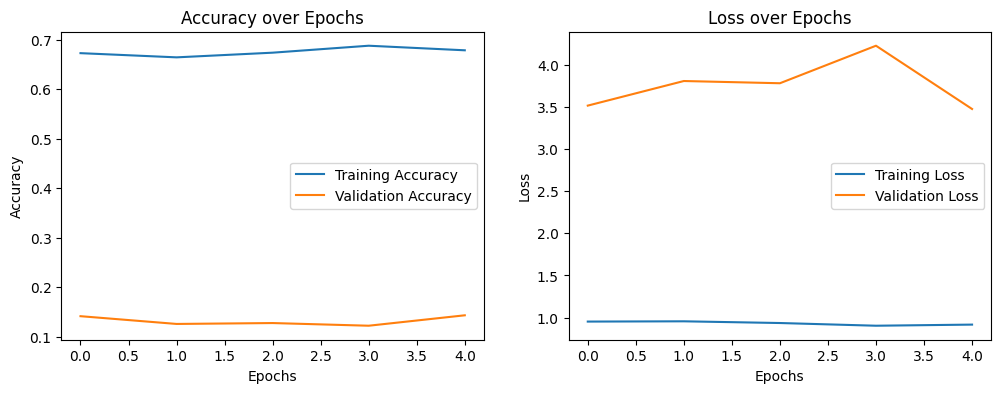

In [13]:
plot_performance(history_manipulated)

### Accuracy Düştü, Neden ?

1. Eğitim ve Test Verisi Arasındaki Dağılım Farkı

   Eğitim sırasında belirli ışık manipülasyonlarının eksikliği, modelin farklı ışık koşullarına genelleme yapma yeteneğini kısıtlayabilir. Model, eğitimde görmediği veri türlerine karşı performans gösteremeyebilir. Bu durum, eğitim ve test verisi arasındaki dağılım farkı olarak bilinir. Bu sorunun önüne geçmek için eğitim veri seti çeşitlendirilmeli, farklı ışık koşullarını ve manipülasyonları içerecek şekilde genişletilmelidir.

2. Işık Manipülasyonlarının Görüntü Özelliklerine Etkisi

   Mor, turuncu ve yeşil ışık altında resimlerin renk dağılımları, kontrastları ve dokusal özellikleri değişir. Bu değişiklikler, modelin evrişimsel katmanlar aracılığıyla çıkardığı özelliklerin bozulmasına neden olabilir ve sınıflandırma performansını düşürebilir. Hem eğitim hem de test verilerine Renk Sabitliği Algoritması uygulanarak, ışık koşullarının neden olduğu bu olumsuz etkiler azaltılabilir.

3. Modelin Renk Özelliklerine Aşırı Bağımlılığı

   Model, sınıflandırma yaparken renk bilgisine fazla bağımlı hale gelmiş olabilir. Bu durumda, renk özelliklerini de kapsayan veri artırma yöntemleri uygulanabilir. Alternatif olarak, gri tonlama veya kenar algılama gibi yöntemler kullanılarak, modelin renk dışındaki ayırt edici özelliklere (dokusal ve geometrik) odaklanması sağlanabilir.

## Renk Sabitliği Algoritması

Son olarak, farklı ışıklarla manipüle edilmiş bu veriler, ***save_manipulated_col_images*** fonksiyonu kullanılarak Renk Sabitliği Algoritması'na (Color Constancy Algorithm) tabi tutulur. Elde edilen sonuçlar, model performansı açısından yeniden değerlendirilir.

In [14]:
test_manipulated_image_dir = '/kaggle/working/manipulated_images'

output_col_dir = '/kaggle/working/wbimages'

save_manipulated_col_images(test_manipulated_image_dir, output_col_dir)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_24/2541434558.py:400: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite(color_path, cv2.cvtColor((srgb_grey_world * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))


Renkli görüntüler başarıyla /kaggle/working/wbimages dizinine kaydedildi!


In [15]:
test_generator_wb = test_data_generator.flow_from_directory(output_col_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle= False
    )

history_wb = model.fit(
    train_generator,
    validation_data=test_generator_wb,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Found 3900 images belonging to 10 classes.
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 428ms/step - accuracy: 0.6727 - loss: 0.9369 - val_accuracy: 0.1000 - val_loss: 4.0910
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 429ms/step - accuracy: 0.6747 - loss: 0.9316 - val_accuracy: 0.1000 - val_loss: 4.4759
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 428ms/step - accuracy: 0.6831 - loss: 0.9081 - val_accuracy: 0.1000 - val_loss: 4.3958
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 431ms/step - accuracy: 0.6826 - loss: 0.9285 - val_accuracy: 0.1000 - val_loss: 4.9722
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 429ms/step - accuracy: 0.6792 - loss: 0.9115 - val_accuracy: 0.1000 - val_loss: 4.3767


Modelin doğruluk oranı **%10** olarak bulunmuştur.

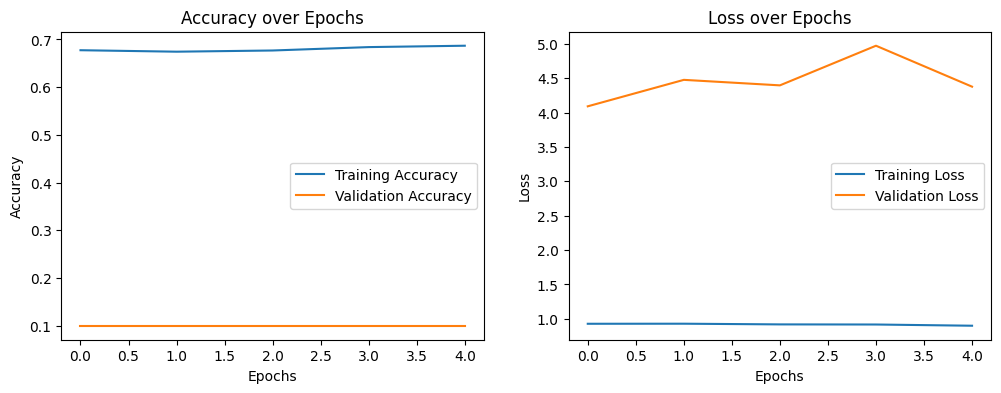

In [16]:
plot_performance(history_wb)

1. Modelin Renk Bazlı Özelliklere Aşırı Bağımlılığı

    Farklı renk spektrumlarında test edilen resimler, modelin genel yapıyı algılama yeteneğini bozabilir. Bu durum, modelin renk bazlı özelliklere gereğinden fazla bağımlı olmasından kaynaklanabilir.
    Modelin renk yerine dokusal ve şekil bilgilerine odaklanmasını sağlamak için mimari değişiklikler yapılabilir.

2. Dokusal ve Geometrik Özelliklerin Yetersiz Öğrenilmesi

    Renk sabitliği algoritması, görüntüdeki renk etkilerini azaltır. Ancak, model renk dışındaki dokusal veya geometrik özellikleri yeterince öğrenememişse, bu durum doğruluk oranını düşürebilir.
    Daha karmaşık ve katmanlı bir model kullanılarak modelin bu tür özellikleri daha iyi öğrenmesi sağlanabilir.

3. Eğitim ve Test Verisi Arasındaki Uyumsuzluk

    Renk sabitliği algoritmasının sadece test verisine uygulanması, modelin genelleme yeteneğini olumsuz etkileyebilir. Eğitim ve test verileri arasında bir uyumsuzluk oluşabilir.
    Eğitim veri setine de renk sabitliği algoritması uygulanarak modelin bu duruma adapte olması sağlanabilir. Alternatif olarak, eğitim sırasında veri artırma teknikleri kullanılarak benzer manipülasyonlar eklenebilir.

4. Veri Artırma Yöntemlerinin Yetersizliği

    Eğitim sırasında kullanılan veri artırma yöntemleri (örneğin, resim döndürme gibi işlemler) yetersiz kalmış olabilir. Modelin daha fazla şekil ve dokusal bilgi öğrenmesi sağlanmalıdır.
    Veri artırma sırasında, resimlerin dokusal özelliklerini vurgulayan teknikler kullanılabilir. Örneğin, kenar algılama veya gri tonlama gibi işlemlerle modelin şekil bilgilerine odaklanması sağlanabilir.